In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing
from tensorflow.keras.utils import to_categorical

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
X = df["cleaned"]
y = df["aspect_polarity"]

In [6]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [7]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [8]:
X_train_review = df_train["review"]
X_train_aspect = df_train["aspect"]
X_train_sentiment = df_train["aspect_polarity"]

In [9]:
X_valid_review = df_validation["review"]
X_valid_aspect = df_validation["aspect"]
X_valid_sentiment = df_validation["aspect_polarity"]

In [10]:
X_test_review = df_test["review"]
X_test_aspect = df_test["aspect"]
X_test_sentiment = df_test["aspect_polarity"]

In [11]:
tokenizer_review = preprocessing.text.Tokenizer()
tokenizer_review.fit_on_texts(df["cleaned"])

In [12]:
tokenizer_aspect = preprocessing.text.Tokenizer()
tokenizer_aspect.fit_on_texts(df["cleaned"])

In [13]:
max_review_len = 64
max_aspect_len = 16

In [14]:
X_train_review = tokenizer_review.texts_to_sequences(X_train_review)
X_train_review = preprocessing.sequence.pad_sequences(X_train_review, maxlen=max_review_len)

In [15]:
X_train_aspect = tokenizer_aspect.texts_to_sequences(X_train_aspect)
X_train_aspect = preprocessing.sequence.pad_sequences(X_train_aspect, maxlen=max_aspect_len)

In [16]:
X_valid_review = tokenizer_review.texts_to_sequences(X_valid_review)
X_valid_review = preprocessing.sequence.pad_sequences(X_valid_review, maxlen=max_review_len)

In [17]:
X_valid_aspect = tokenizer_aspect.texts_to_sequences(X_valid_aspect)
X_valid_aspect = preprocessing.sequence.pad_sequences(X_valid_aspect, maxlen=max_aspect_len)

In [18]:
X_test_review = tokenizer_review.texts_to_sequences(X_test_review)
X_test_review = preprocessing.sequence.pad_sequences(X_test_review, maxlen=max_review_len)

In [19]:
X_test_aspect = tokenizer_aspect.texts_to_sequences(X_test_aspect)
X_test_aspect = preprocessing.sequence.pad_sequences(X_test_aspect, maxlen=max_aspect_len)

In [20]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_review, X_train_aspect), X_train_sentiment))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_sentiment)).batch(batch_size)

In [21]:
valid_dataset = tf.data.Dataset.from_tensor_slices(((X_valid_review, X_valid_aspect), X_valid_sentiment))
valid_dataset = valid_dataset.shuffle(buffer_size=len(X_valid_sentiment)).batch(batch_size)

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_review, X_test_aspect), X_test_sentiment))
test_dataset = test_dataset.shuffle(buffer_size=len(X_test_sentiment)).batch(batch_size)

In [23]:
input1 = layers.Input(shape=(max_review_len,))
input2 = layers.Input(shape=(max_aspect_len,))
embedding_layer1 = layers.Embedding(input_dim=len(tokenizer_review.word_index) + 1, output_dim=max_review_len)
embedding_layer2 = layers.Embedding(input_dim=len(tokenizer_aspect.word_index) + 1, output_dim=max_aspect_len)

embedded_sequences1 = embedding_layer1(input1)
embedded_sequences2 = embedding_layer2(input2)

lstm1 = layers.SimpleRNN(128)(embedded_sequences1)
lstm2 = layers.SimpleRNN(128)(embedded_sequences2)

merged = layers.Concatenate()([lstm1, lstm2])
dense = layers.Dense(64, activation='relu')(merged)
output = layers.Dense(3, activation='softmax')(dense)

model = models.Model(inputs=[input1, input2], outputs=output)

In [24]:
model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 64)       5766208     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 16, 16)       1441552     ['input_2[0][0]']                
                                                                                              

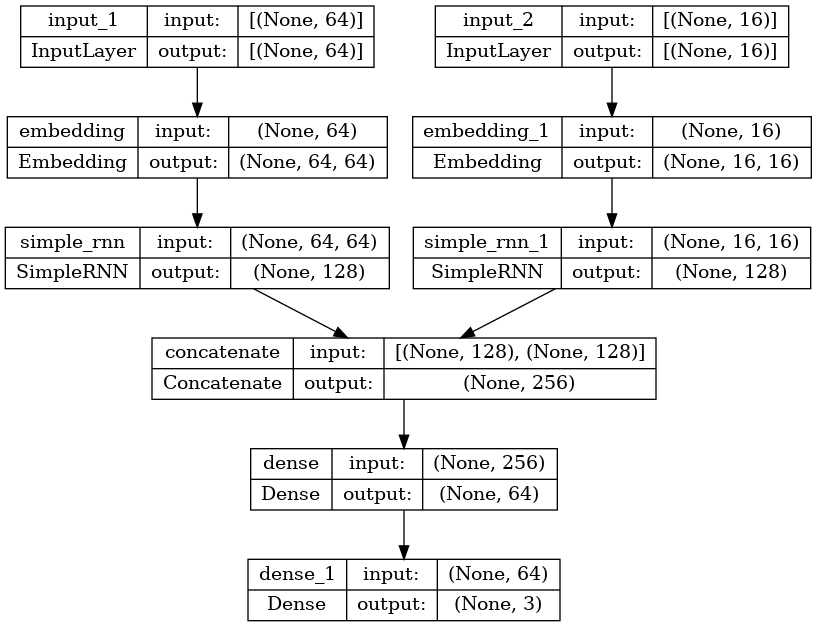

In [26]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True, to_file="./output/rnn_two_input_model_plot.png")

In [27]:
model1_train_start = time.time()
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=3)]
)
model1_train_time = time.time() - model1_train_start
print(f"RNN Train Time = {model1_train_time:.4f}")

Epoch 1/10
2281/2281 [==============================] - 119s 52ms/step - loss: 0.5688 - accuracy: 0.7795 - val_loss: 0.4693 - val_accuracy: 0.8211
Epoch 2/10
2281/2281 [==============================] - 117s 51ms/step - loss: 0.3602 - accuracy: 0.8691 - val_loss: 0.4266 - val_accuracy: 0.8456
Epoch 3/10
2281/2281 [==============================] - 117s 51ms/step - loss: 0.2251 - accuracy: 0.9191 - val_loss: 0.4383 - val_accuracy: 0.8538
Epoch 4/10
2281/2281 [==============================] - 118s 52ms/step - loss: 0.1468 - accuracy: 0.9479 - val_loss: 0.5046 - val_accuracy: 0.8482
Epoch 5/10
2281/2281 [==============================] - 118s 52ms/step - loss: 0.1538 - accuracy: 0.9438 - val_loss: 0.5853 - val_accuracy: 0.8223
Epoch 6/10
2281/2281 [==============================] - 118s 52ms/step - loss: 0.1439 - accuracy: 0.9482 - val_loss: 0.5711 - val_accuracy: 0.8375
RNN Train Time = 708.3553


In [28]:
model1_test_start = time.time()
model_pred_test = model.predict([X_test_review, X_test_aspect], verbose=0)
model1_test_time = time.time() - model1_test_start
print(f"RNN Test Time = {model1_test_time:.4f}")

RNN Test Time = 1.2073


In [29]:
model_pred_train = model.predict([X_train_review, X_train_aspect], verbose=0)
model_pred_train = np.argmax(model_pred_train, axis=1)
model_pred_test = np.argmax(model_pred_test, axis=1)
model_train_score = accuracy_score(model_pred_train, X_train_sentiment)
model_test_score = accuracy_score(model_pred_test, X_test_sentiment)

print(f"RNN Train Score = {model_train_score * 100:.4f}%")
print(f"RNN Test Score = {model_test_score * 100:.4f}%")

RNN Train Score = 97.0486%
RNN Test Score = 83.5471%


In [30]:
model_precision_score = precision_score(X_test_sentiment, model_pred_test, average="macro")
model_f1_score = f1_score(X_test_sentiment, model_pred_test, average="macro")
model_recall_score = recall_score(X_test_sentiment, model_pred_test, average="macro")
model_accuracy_score = accuracy_score(X_test_sentiment, model_pred_test)

print(f"RNN Precision Score = {model_precision_score * 100:.4f}%")
print(f"RNN F1 Score = {model_f1_score * 100:.4f}%")
print(f"RNN Recall Score = {model_recall_score * 100:.4f}%")
print(f"RNN Accuracy Score = {model_accuracy_score * 100:.4f}%")

RNN Precision Score = 74.2026%
RNN F1 Score = 73.1654%
RNN Recall Score = 72.2770%
RNN Accuracy Score = 83.5471%


In [31]:
print(classification_report(X_test_sentiment, model_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      4508
     Neutral       0.53      0.47      0.50       421
    Positive       0.84      0.81      0.83      3179

    accuracy                           0.84      8108
   macro avg       0.74      0.72      0.73      8108
weighted avg       0.83      0.84      0.83      8108



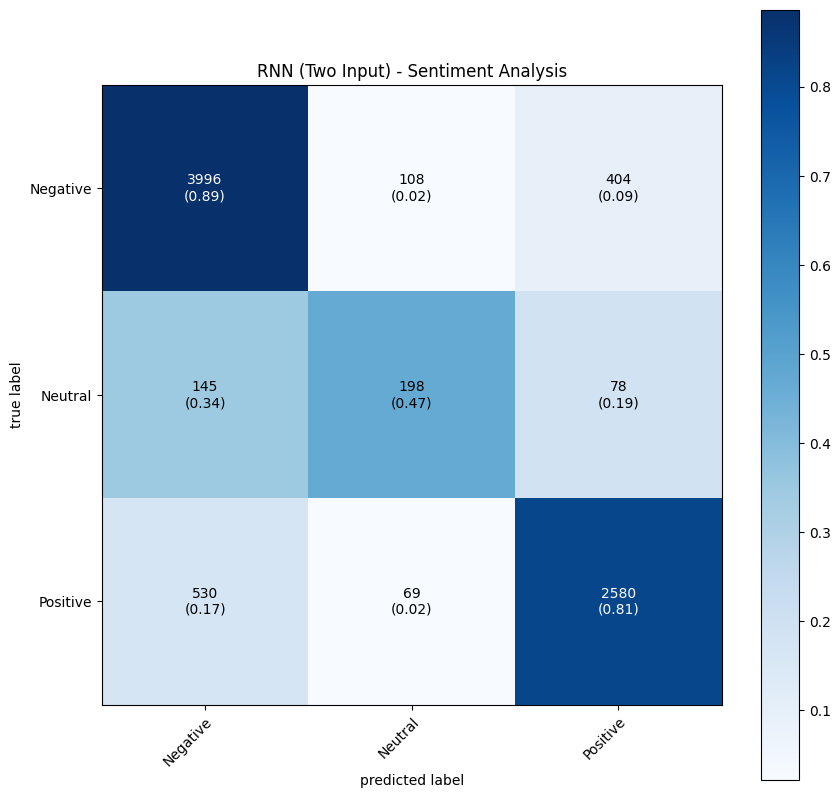

In [33]:
model_cm = confusion_matrix(X_test_sentiment, model_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=model_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("RNN (Two Input) - Sentiment Analysis")
plt.savefig("./output/rnn_two_input.png")
plt.show()